# Linear Discriminant Analysis with Pokemon Stats

## Discussion

**Linear Discriminant Analysis** is a popular technique for performing dimensionality reduction on a dataset. Dimensionality reduction is the reduction of a dataset from $n$ variables to $k$ variables, where the $k$ variables are some combination of the $n$ variables that preserves or maximizes some useful property of the dataset. In the case of Linear Discriminant Analysis, the new variables are chosen (and the data reprojected) in a way that maximizes the _linear separability_ of a certain set of classes in the underlying data.

In other words, given a dataset with $n$ variables, including an embedded set of labels that we want to predict, we can apply LDA to the data and reduce it to $k$ components, where those components are chosen in such a way that they maximize our ability to "draw lines" to distinguish the classes.

So for example, an ideal application of a two-component LDA reduction will look like this:

![](https://i.imgur.com/BERGLQv.png)

The technique was originally introduced by Fischer himself in the 1930s, making it one of the oldest techniques in the book.

An LDA transform is useful as a preprocessing step when modeling classes because it transforms the space in such a way that algorithms which then go and draw those boundaries, like support vector machines, perform much better on the transformed data than on the original projections.

However, it is also useful as an EDA technique. In this application, LDA can be compared to PCA. PCA is another dimensionality reduction technique (which I cover in detail in [this notebook](https://www.kaggle.com/residentmario/dimensionality-reduction-and-pca-for-fashion-mnist/)) that creates new variables that maximize the *variance* of the underlying dataset. As such, it functions in the absence of data labels (it is an unsupervised technique). LDA, meanwhile, is based on categorical labels, and creates new variables that maximize the *linear distinguishability* of the underlying dataset.

PCA is an interesting technique to try out on a broad variety of datasets because it will teach us how the variables are interact with one another, finding axes in the dataset which make intrinsic sense and might potentially even be worth creating new features for.

When we have meaningfully labelled data, LDA is another great technique to try out. Applying LDA to a dataset will tell us how linearly separable our dataset is (which, depending on the context, may also be a commentary on howmeaningful our labels are). That, in turn, is a good marker of how hard we will have to work to generate a model with reasonable classification performace. Furthermore, by looking at what variables load highly, we can determine what elements of the dataset are the strongest signals for each of our classes

## Mathematics

A mathematical sketch of LDA is as follows. Suppose that $f_k(x)$ is the conditional probability that a point with features $x$ is in the class $G=k$. Let $\pi_k$ is be the probability that any one of these classes will occur (e.g. so that $\sum_k \pi_k  = 1$).

Baye's theorem holds that:

$$P(G=k \: | \: X=x) = \frac{f_k(x)\pi_k}{\sum_{k} f_k(x) \pi_k}$$

Assume that all of the classes have a common covariance matrix ($\sum_k = \sum_k \forall k$) and that the classes are distributed as multivariate Gaussian distributions (e.g. each class of points is distributed normally across each of the $n$ variables).

Then we may look at the [log-odds](https://www.kaggle.com/residentmario/logistic-regression-with-wta-tennis-matches/) of two classes ($k$ and $l$), and find that:

$$\log{\frac{P(G=k\: | \: X=x)}{P(G=l \: | \: X=x)}} = \log{\frac{f_k(x)}{f_k(x)}} + \log{\frac{\pi_k}{\pi_l}}$$
$$= \log{\frac{\pi_k}{\pi_l} - \frac{1}{2}(\mu_k + \mu_l)^T \sum^{-1}(\mu_k - \mu_l)} + x^T \sum^{-1}(\mu_k - \mu_l)$$

What this all means mathematically is unimportant. What matters is that, due to the equal covariance matrix condition, the math simplifies to an equation linear in $x$ (the last line). Thus this is a statement that, given multivariate normal distributions with a common covariance matrix, the log-odds between any two classes is a linear function.

That in turn implies that the decision boundaries between any $k$ and $l$ (the set $\{x \: | \: P(G=k|X=x) = P(G=l|X=x)\}$, e.g. the set of points such that the probability of a point being in either one of these classes is 50/50) is linear as well. Convexity in turn implies that the separators between the classes are hyperplanes. Hence the optimal solution for this classification problem will be:

$$G(x) = \text{argmax}_k\left(\delta_k (x) = x^T \sum^{-1} \mu_k - \frac{1}{2} \mu_k^T \sum^{-1} \mu_k + \log{\mu_k}\right)$$

Which is a convex function of $x$, and hence can be proveably solved using [gradient descent](https://www.kaggle.com/residentmario/gradient-descent-with-linear-regression/) or related optimization algorithms.

So for the given set of conditions (Gaussian distributions and equal covariance matrices), LDA remaps the data to an ideally linearly separable space. These conditions are rarely met in practice exactly, but many classification task datasets are "close enough" to separability that LDA is a useful technique to try out on them.

## Application

In this notebook we will try out using LDA for exploring the Pokemon dataset. Our goal is to predict the type of Pokemon based only on its stat totals. Let's see what happens.

### Data munging

In [6]:
import pandas as pd
pokemon = pd.read_csv('C://Users//DEEPIKA//Documents//Machine Learning//Discriminant Analysis//Linear Discriminant Analysis//pokemon.csv')
pokemon.head(3)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0


In [7]:
len(pokemon[pokemon['type2'].isnull()])

384

In order to avoid stat munging due to Pokemon with combined types, we're going to focus only on Pokemon with a single type (e.g. no dual types allowed).

Notice also that we're normalizing the data before applying LDA. [Normalization isn't strictly necessary](http://sebastianraschka.com/Articles/2014_python_lda.html#a-note-about-standardization), as you will get the same result without it, just with differently sized numbers. I apply normalization as a preprocessing step here in order to make the class coefficients larger (and a bit easier on the eyes).

In [9]:
df = pokemon[pokemon['type2'].isnull()].loc[
    :, ['sp_attack', 'sp_defense', 'attack', 'defense', 'speed', 'hp', 'type1']
]
X = df.iloc[:, :-1].values

from sklearn.preprocessing import normalize
X_norm = normalize(X)

y = df.iloc[:, -1].values

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_norm, y)

LinearDiscriminantAnalysis(n_components=3)

Q: What is the deal with these priors?

### Assessing class-wise variable importance using LDA coefficients

PCA provides a `components_` attribute to the fitted reducer, which allows us to directly access the vector components. LDA does not provide this attribute. This is because in LDA, the methodology for transforming a vector is [a bit more complicated](https://stackoverflow.com/a/15927777/1993206) than a simple `w.T * x` reprojection.

An LDA instead provides a `coef_` attribute, which is analogous, albeit more mathematically complicated. The magnitudes of the components in the `coef_` tell us how heavily each of the features loads towards the seperability of that class.

If a particular class has a particularly high-magnitude coefficient (direction, positive or negative, notwithstanding) then that variable signals that class very well. That variable will factor very heavily into the LDA preprojection. A low-magnitude coefficient, meanwhile, corresponds with a weak signal, and hence will be mostly rubbed out in the reprojection.

If a class has mostly low-magnitude coefficients, that means that it is not easily linearly separable! That class is relatively close to the mean of the dataset or (in the weaker cases) relatively close to a subset of other classes in the dataset.

The heatmap that follows demonstrates what this maps out to:

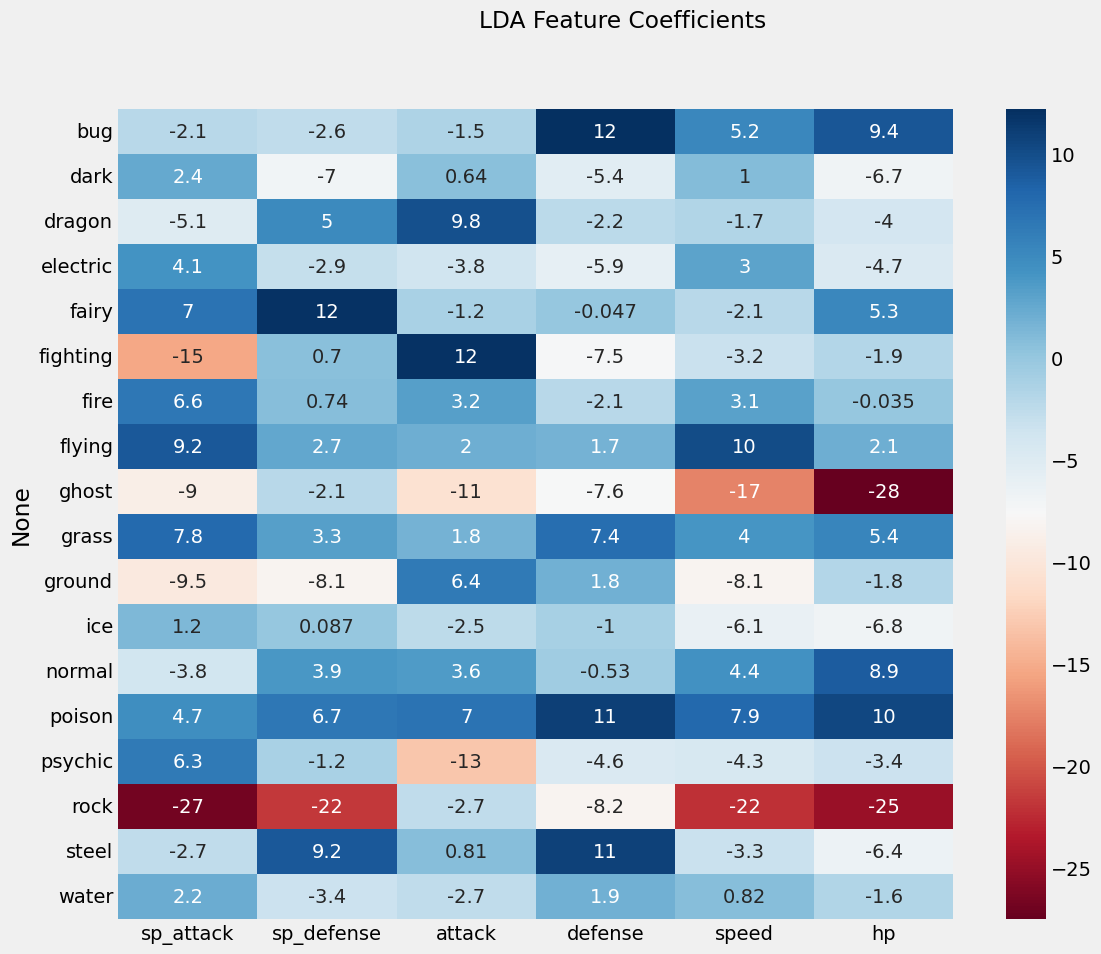

In [12]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

sns.heatmap(pd.DataFrame(lda.coef_, 
                         columns=df.columns[:-1], 
                         index=[lda.classes_]), 
            ax=ax, cmap='RdBu', annot=True)

plt.suptitle('LDA Feature Coefficients')
pass

In this heatmap we see classes which are probably easier to separate, given their large variable coefficients, as well as classes which are probably much harder.

A good example of a separable class is the `rock` type. Rock type Pokemon load very strongly on all of Special Attack, Special Defense, Speed, and HP, implying that a combination of these stats makes up the Rock archetype. Other highly separable classes are the `ghost` type and the `fighting` type, which both sport some high-magnitude coefficients.

`ice` and `water` are two classes that have very low class separability. They both have coefficients that are mostly close to 0.

We can summarize this heatmap by looking at the absolute coefficient totals for each of the classes. 

<AxesSubplot:title={'center':'LDA Class Coefficient Sums'}>

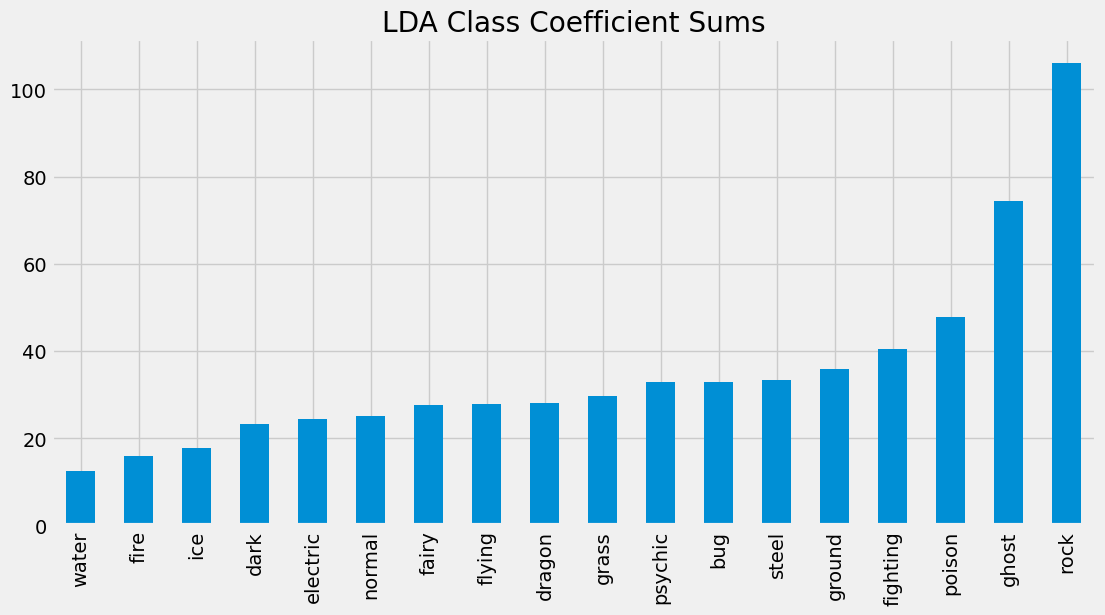

In [13]:
pd.Series(np.abs(lda.coef_).sum(axis=1), index=lda.classes_).sort_values().plot.bar(
    figsize=(12, 6), title="LDA Class Coefficient Sums"
)

Again, we see that `rock` and `ghost` is much more separable than `water` and `ice`.

The y-values in both the heatmap and the bar plot can be treated as indicial. Higher is better, but the numbers themselves are not particularly interpretable (at least, my math isn't strong enough to interpret them immediately; feel free to think otherwise in the comments).

To see what this difference translates to and to understand how well we perform overall, we need to move on to applying our LDA.

### Assessing linear classifier performance by applying the LDA projection

To start with, as with any dimensionality reduction technique, it's important to note that each additional component used by the model adds less and less "gain" to the reconstructions. For example, here are the top three explained variances of the LDA decomposition:

In [14]:
lda.explained_variance_ratio_

array([0.48036548, 0.21001446, 0.13047873])

Recall that PCA picks values which maximize these values directly. LDA picks values that maximize the differences between classes, so the `explained_variance_ratio_` will not correlate *exactly* with the usefulness of this or that particular vector. However, in practice LDA creates axes which are *reasonably* close to the axes created by PCA (maximizing explained variance and maximizing class separability are reasonably similar tasks). Hence the explained variance scores are still a useful meterstick, and sharp breaks in the amount of variance explained by each component is useful for "cutting off" how many components we will include in our dataset (as I demonstrated in the [PCA notebook](https://www.kaggle.com/residentmario/dimensionality-reduction-and-pca-for-fashion-mnist/)).

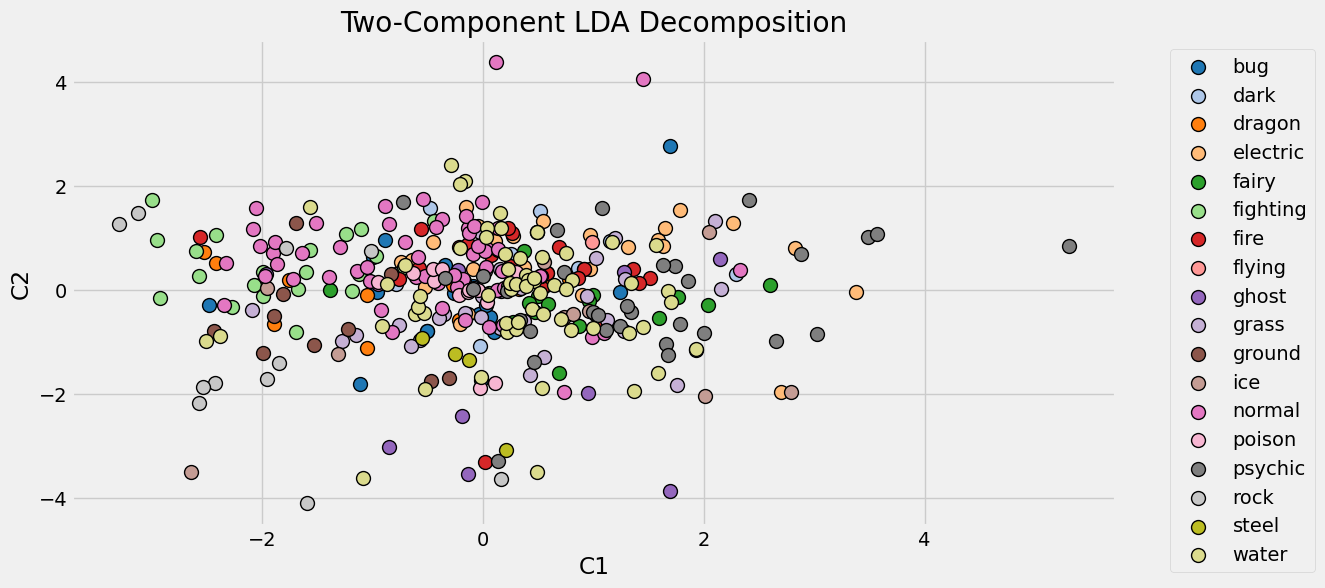

In [15]:
X_hat = lda.fit_transform(X, y)

import matplotlib as mpl

colors = mpl.cm.get_cmap(name='tab20').colors
categories = pd.Categorical(pd.Series(y)).categories
ret = pd.DataFrame(
    {'C1': X_hat[:, 0], 'C2': X_hat[:, 1], 'Type': pd.Categorical(pd.Series(y))}
)

fig, ax = plt.subplots(1, figsize=(12, 6))

for col, cat in zip(colors, categories):
    (ret
         .query('Type == @cat')
         .plot.scatter(x='C1', y='C2', color=col, label=cat, ax=ax,
                       s=100, edgecolor='black', linewidth=1,
                       title='Two-Component LDA Decomposition')
         .legend(bbox_to_anchor=(1.2, 1))
    )

This is a convoluted mess! What do we learn? We've learned that **different classes of Pokemon are not very linearly distinguishable by stats alone**.

In summary this plot tells us that classifying Pokemon using stats alone is a non-linear problem. This in turn tells us that given the current set of features, predicting Pokemon type is *a very hard classification problem*. Most problems that are not linearly separable are very hard, unless (1) there are unusually complicated data dependencies like [spiral structures](https://stats.stackexchange.com/questions/235600/how-to-classify-data-which-is-spiral-in-shape) or (2) we are able to gather additional (useful) features.

Domain knowledge in Pokemon tells us that this is probably true, so in a sense this is something I already knew. In fact, I tested this very same concept using PCA and SVM [in another notebook I wrote long ago](https://www.kaggle.com/residentmario/classifying-pokemon-type-by-stat-allocation); you should read that notebook to see the effect that such an attribute soup has on our attempts to classify our data!

## Conclusion

In this notebook I covered LDA (Linear Discriminant Analysis) in depth. LDA is a dimensionality reduction technique which is a first tool of choice when working with classification tasks. As an EDA technique it tells us a lot about the complexity of our problem, and tells us which classes are most easily distinguishable and why. As a preprocessing technique it improves model performace for any useful model we apply to the dataset afterwards, but particularly for linear ones, like SVMs.

For more quantitatively oriented details on this technique, [check out this excellent blog post](http://sebastianraschka.com/Articles/2014_python_lda.html#a-note-about-standardization).

See also [this Reddit post](https://www.reddit.com/r/dataisbeautiful/comments/7ke5a6/the_christmas_cookie_competition_at_my_office/drdpuh8/) for the inspiration for this notebook.